<a href="https://colab.research.google.com/github/Ares1510/Learning-PyTorch/blob/main/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch
import torchmetrics
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, TensorDataset
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [3]:
# Device agnostic code
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# Preprocessing steps
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

train = datasets.MNIST('/MNIST', download=True, train=True, transform=transform)

# DataLoader is used to batch the data
train_loader = DataLoader(train, batch_size=512, shuffle=False)

# Sending the entire dataset to the GPU to speed up training
train_loader = [(x.to(device), y.to(device)) for x, y in train_loader]

In [5]:
test = datasets.MNIST('/MNIST', download=True, train=False, transform=transform)

# Creating the test DataLoader
test_loader = DataLoader(test, batch_size=512, shuffle=False)

# Sending the test data to the GPU
test_loader = [(x.to(device), y.to(device)) for x, y in test_loader]

In [6]:
for x, y in train_loader:
  print(x.min(), x.max()) # Should be between -1 and 1
  print(x.shape)
  print(y.shape)
  break

tensor(-1., device='cuda:0') tensor(1., device='cuda:0')
torch.Size([512, 1, 28, 28])
torch.Size([512])


In [7]:
# Definig the model class. All models inherit the nn.Module class
class MyNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    
    # Defining the layers of the network
    self.fc1 = nn.Linear(28*28, 128)
    self.do1 = nn.Dropout(0.3)
    self.fc2 = nn.Linear(128, 64)
    self.do2 = nn.Dropout(0.3)
    self.fc3 = nn.Linear(64, 10)

  # Defining the forward pass of the network
  def forward(self, X):
    X = X.view(-1, 28*28)
    X = self.do1(F.relu(self.fc1(X)))
    X = self.do2(F.relu(self.fc2(X)))
    X = self.fc3(X)
    return X

In [8]:
# Creating the model instance
model = MyNetwork().to(device)

# Loss is referred to as criterion in PyTorch
criterion = nn.CrossEntropyLoss()
# Defining the optimizer. Need to pass the model parameters here
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Creating torchmetrics 
train_metric = torchmetrics.Accuracy(task='multiclass', num_classes=10).to(device)
test_metric = torchmetrics.Accuracy(task='multiclass', num_classes=10).to(device)

In [9]:
# Defining the training loop
epochs = 21

# Capturing train and test metrics
train_hist = {'loss': [], 'acc': []}
test_hist = {'loss': [], 'acc': []}

for epoch in range(1, epochs):
  # Setting model to train mode
  model.train()
  train_loss = 0.0

  for X, y in train_loader:
    # Zeroing the gradients of the optimizer
    optimizer.zero_grad()

    # Forward pass of the model
    output = model(X)
    # Calculating the loss
    loss = criterion(output, y)
    # Calculating the gradients with respect to the loss
    loss.backward()
    # Performing one step of gradient descent
    optimizer.step()

    # Calculating the metrics for the entire batch
    train_loss += loss.item()
    preds = F.softmax(output, dim=1)
    train_metric(preds, y)

  train_loss = train_loss / len(train_loader)
  train_acc = train_metric.compute()
  # Resetting torchmetric after every epoch
  train_metric.reset()

  train_hist['loss'].append(train_loss)
  train_hist['acc'].append(train_acc.cpu())

  # Printing the metrics
  print(f'Epoch: {epoch}, Train Loss: {train_loss: .4f}, Train Accuracy: {train_acc: .4f}')

  # Setting the model to evaluation mode
  model.eval()
  test_loss = 0.0

  # This turns of autograd to speed up calculations
  with torch.no_grad():
    for X, y in test_loader:

      # Forward pass of the model 
      output = model(X)
      # Calculating the loss
      loss = criterion(output, y)

      test_loss += loss.item()
      preds = F.softmax(output, dim=1)
      test_metric(preds, y)
    
  test_loss = test_loss / len(test_loader)
  test_acc = test_metric.compute()
  # Resetting torchmetric after every epoch
  test_metric.reset()

  test_hist['loss'].append(test_loss)
  test_hist['acc'].append(test_acc.cpu())

  # Printing the metrics
  print(f'Epoch: {epoch}, Val Loss: {test_loss: .4f}, Val Accuracy: {test_acc: .4f}')

Epoch: 1, Train Loss:  0.9340, Train Accuracy:  0.7027
Epoch: 1, Val Loss:  0.3453, Val Accuracy:  0.8984
Epoch: 2, Train Loss:  0.4252, Train Accuracy:  0.8726
Epoch: 2, Val Loss:  0.2631, Val Accuracy:  0.9203
Epoch: 3, Train Loss:  0.3428, Train Accuracy:  0.8996
Epoch: 3, Val Loss:  0.2169, Val Accuracy:  0.9334
Epoch: 4, Train Loss:  0.2994, Train Accuracy:  0.9121
Epoch: 4, Val Loss:  0.1962, Val Accuracy:  0.9417
Epoch: 5, Train Loss:  0.2667, Train Accuracy:  0.9223
Epoch: 5, Val Loss:  0.1762, Val Accuracy:  0.9460
Epoch: 6, Train Loss:  0.2436, Train Accuracy:  0.9279
Epoch: 6, Val Loss:  0.1637, Val Accuracy:  0.9505
Epoch: 7, Train Loss:  0.2256, Train Accuracy:  0.9334
Epoch: 7, Val Loss:  0.1486, Val Accuracy:  0.9555
Epoch: 8, Train Loss:  0.2100, Train Accuracy:  0.9377
Epoch: 8, Val Loss:  0.1373, Val Accuracy:  0.9595
Epoch: 9, Train Loss:  0.1991, Train Accuracy:  0.9406
Epoch: 9, Val Loss:  0.1331, Val Accuracy:  0.9607
Epoch: 10, Train Loss:  0.1913, Train Accuracy

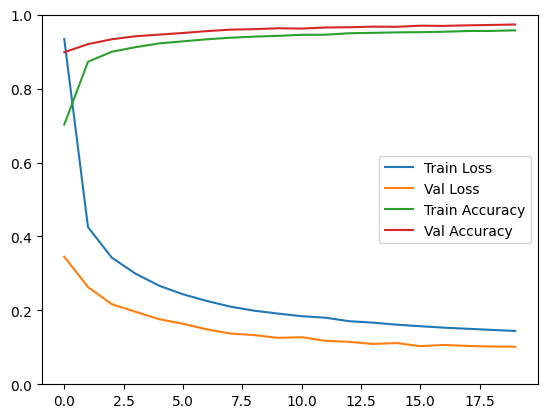

In [10]:
# Plotting the train and test loss and accuarcy
plt.plot(train_hist['loss'], label='Train Loss')
plt.plot(test_hist['loss'], label='Val Loss')
plt.plot(train_hist['acc'], label='Train Accuracy')
plt.plot(test_hist['acc'], label='Val Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.show()